<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/semester_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:
add test options in and out of money
add log price as second input
try equally spaced distribution

In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
!pip install tf-quant-finance
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price


In [83]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm

In [84]:
# option price generation parameters
TOT_OPTIONS = 1000
EXPIRY = 1.0
RATE = 0.0
SPOT = 200
STRIKE_MIN = 50
STRIKE_MAX = 250
VOLATILITY = 0.35

LAMBDA = SPOT / 3 # scaling factor for spot and strike
SPOT_SCALED = SPOT/LAMBDA
STRIKE_MIN_SCALED = STRIKE_MIN/LAMBDA
STRIKE_MAX_SCALED = STRIKE_MAX/LAMBDA
SCALED_VOLATILITY = VOLATILITY/LAMBDA

# NN parameters
MC_STEPS_STARTING = 2**8
MC_STEPS_FINAL = 2**14

EPOCHS = 100
batch_size = 16


#distribution parameters
PROPOSAL_SIGMA = SCALED_VOLATILITY #0.3/10 * 4 sigma should not be divided 
PROPOSAL_MU_SCALED = np.log(SPOT_SCALED) - 0.5 * PROPOSAL_SIGMA**2 
PROPOSAL_MU = np.log(SPOT) - 0.5 * VOLATILITY**2

#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0.01

#Generate train and test data

In [85]:
"""
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices
"""

'\n# Calculate discount factors (e^-rT)\nrate = 0.05\nexpiries = np.array([0.5, 1.0, 2.0, 1.3])\ndiscount_factors = np.exp(-rate * expiries)\n# Current value of assets.\nspots = np.array([0.9, 1.0, 1.1, 0.9])\n# Forward value of assets at expiry.\nforwards = spots / discount_factors\n# Strike prices given by:\nstrikes = np.array([1.0, 2.0, 1.0, 0.5])\n# Indicate whether options are call (True) or put (False)\nis_call_options = np.array([True, True, False, False])\n# The volatilites at which the options are to be priced.\nvolatilities = np.array([0.7, 1.1, 2.0, 0.5])\n# Calculate the prices given the volatilities and term structure.\nprices = option_price(\n      volatilities=volatilities,\n      strikes=strikes,\n      expiries=expiries,\n      forwards=forwards,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\nprices\n'

In [86]:
rates = np.array([RATE]*TOT_OPTIONS)
discount_factors = np.exp(- (rates)*EXPIRY)
spots = np.array([SPOT]*TOT_OPTIONS)
forwards = spots / discount_factors
strikes = np.linspace(STRIKE_MIN, STRIKE_MAX, TOT_OPTIONS) #[50., 60. , 75., 110., 125., 135. ]  #
is_call_options = np.random.choice(a=[False, True], size=(TOT_OPTIONS,)) #[True, True, True, False, False, False] #
volatilities = np.array([VOLATILITY]*TOT_OPTIONS)
expiries = np.array([EXPIRY]*TOT_OPTIONS)
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [87]:
prices

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([1.50000293e+02, 1.49800109e+02, 1.49599925e+02, 1.49399742e+02,
       1.49199560e+02, 1.48999378e+02, 3.98922986e-04, 1.48599018e+02,
       1.48398839e+02, 4.63375051e-04, 4.86798809e-04, 5.11253427e-04,
       1.47598134e+02, 5.63409353e-04, 1.47197788e+02, 6.20162497e-04,
       1.46797447e+02, 1.46597278e+02, 7.14657887e-04, 1.46196945e+02,
       7.84428336e-04, 1.45796617e+02, 8.60068524e-04, 1.45396296e+02,
       9.41989201e-04, 1.44995980e+02, 1.44795825e+02, 1.07760011e-03,
       1.44395521e+02, 1.17716845e-03, 1.43995224e+02, 1.43795078e+02,
       1.34149524e-03, 1.43394794e+02, 1.43194655e+02, 1.52537591e-03,
       1.59134038e-03, 1.42594252e+02, 1.42394123e+02, 1.42193996e+02,
       1.41993873e+02, 1.41793751e+02, 2.04145324e-03, 1.41393518e+02,
       2.21412895e-03, 2.30509705e-03, 1.40793190e+02, 2.49674928e-03,
       2.59762173e-03, 2.70198741e-03, 2.80994572e-03, 1.39792711e+02,
       1.39592627e+02, 1.393

In [88]:
scaled_prices = np.array(prices/LAMBDA)

In [89]:
print(strikes)
print(is_call_options)

[ 50.          50.2002002   50.4004004   50.6006006   50.8008008
  51.001001    51.2012012   51.4014014   51.6016016   51.8018018
  52.002002    52.2022022   52.4024024   52.6026026   52.8028028
  53.003003    53.2032032   53.4034034   53.6036036   53.8038038
  54.004004    54.2042042   54.4044044   54.6046046   54.8048048
  55.00500501  55.20520521  55.40540541  55.60560561  55.80580581
  56.00600601  56.20620621  56.40640641  56.60660661  56.80680681
  57.00700701  57.20720721  57.40740741  57.60760761  57.80780781
  58.00800801  58.20820821  58.40840841  58.60860861  58.80880881
  59.00900901  59.20920921  59.40940941  59.60960961  59.80980981
  60.01001001  60.21021021  60.41041041  60.61061061  60.81081081
  61.01101101  61.21121121  61.41141141  61.61161161  61.81181181
  62.01201201  62.21221221  62.41241241  62.61261261  62.81281281
  63.01301301  63.21321321  63.41341341  63.61361361  63.81381381
  64.01401401  64.21421421  64.41441441  64.61461461  64.81481481
  65.01501502  

In [90]:
scaled_prices

array([2.25000440e+00, 2.24700163e+00, 2.24399887e+00, 2.24099613e+00,
       2.23799339e+00, 2.23499067e+00, 5.98384479e-06, 2.22898527e+00,
       2.22598259e+00, 6.95062577e-06, 7.30198213e-06, 7.66880141e-06,
       2.21397202e+00, 8.45114030e-06, 2.20796683e+00, 9.30243746e-06,
       2.20196171e+00, 2.19895918e+00, 1.07198683e-05, 2.19295418e+00,
       1.17664250e-05, 2.18694926e+00, 1.29010279e-05, 2.18094443e+00,
       1.41298380e-05, 2.17493971e+00, 2.17193738e+00, 1.61640017e-05,
       2.16593281e+00, 1.76575268e-05, 2.15992836e+00, 2.15692618e+00,
       2.01224287e-05, 2.15092191e+00, 2.14791982e+00, 2.28806386e-05,
       2.38701057e-05, 2.13891379e+00, 2.13591185e+00, 2.13290995e+00,
       2.12990809e+00, 2.12690627e+00, 3.06217985e-05, 2.12090277e+00,
       3.32119342e-05, 3.45764558e-05, 2.11189785e+00, 3.74512392e-05,
       3.89643260e-05, 4.05298112e-05, 4.21491857e-05, 2.09689067e+00,
       2.09388940e+00, 2.09088819e+00, 2.08788703e+00, 2.08488594e+00,
      

In [91]:
#scaled version
"""
spots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)
forwards_scaled = spots_scaled / discount_factors
strikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #
prices_scaled = option_price(
      volatilities=volatilities,
      strikes=strikes_scaled,
      expiries=expiries,
      forwards=forwards_scaled,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
      """

'\nspots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)\nforwards_scaled = spots_scaled / discount_factors\nstrikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #\nprices_scaled = option_price(\n      volatilities=volatilities,\n      strikes=strikes_scaled,\n      expiries=expiries,\n      forwards=forwards_scaled,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\n      '

In [92]:
# Jakob suggestion
"""
START_UNIF=0
INTERVAL_LENGTH=20
MC_STEPS=20000
coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)
coordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)
print(coordinates)
"""

'\nSTART_UNIF=0\nINTERVAL_LENGTH=20\nMC_STEPS=20000\ncoordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)\ncoordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)\nprint(coordinates)\n'

In [93]:
from torch.utils.data import DataLoader
scaled_strikes = strikes / LAMBDA
prices_and_strikes = [ (scaled_prices[i], scaled_strikes[i], is_call_options[i]) for i in range(TOT_OPTIONS)]
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

## In and out of the money options for testing

In [94]:
STRIKE_IDM_MIN = 1
STRIKE_IDM_MAX = STRIKE_MIN

STRIKE_OTM_MIN = STRIKE_MAX 
STRIKE_OTM_MAX = 3*STRIKE_MAX

In [95]:
test_strikes = np.concatenate([np.linspace(STRIKE_IDM_MIN, STRIKE_IDM_MAX, TOT_OPTIONS//2), np.linspace(STRIKE_OTM_MIN, STRIKE_OTM_MAX, TOT_OPTIONS//2)]) 
test_prices = option_price(
      volatilities=volatilities,
      strikes=test_strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [96]:
test_prices_scaled = test_prices / LAMBDA

In [97]:
test_strikes_scaled = test_strikes / LAMBDA
test_prices_and_strikes = [ (test_prices_scaled[i], test_strikes_scaled[i], is_call_options[i]) for i in range(TOT_OPTIONS)]
test_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

#Model and loss

In [98]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
    
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x

class LognormalNet(nn.Module):
  def __init__(self):
    super(LognormalNet, self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([PROPOSAL_SIGMA]))
    self.mu = nn.Parameter(torch.Tensor([PROPOSAL_MU]))

  def forward(self, x):
    return 1/(x * self.sigma * np.sqrt(2* np.pi)) * torch.exp(-(torch.log(x) - self.mu)**2 / (2* self.sigma**2) )

In [99]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [100]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(MC_STEPS), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(MC_STEPS), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH #torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs / densities
          #print(coordinates)
          #print(strikes[j])
          #print(numerator)
          #print(mc_price)
          #plt.scatter(coordinates,payoff(j))
          #plt.xlim(-1,20)
          #plt.ylim(-1,20)
          #print(payoff(j))
          #print(mc_price)
          #print(mc_price.sum() / MC_STEPS)
          loss += (labels[j] -  mc_price.sum() / MC_STEPS)**2
          #loss += (labels[j] - mc_price.sum() / MC_STEPS)**2

        
        """
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        """
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            

In [101]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [102]:
loss_history = []
for epoch in tqdm(range(EPOCHS)):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        if epoch < EPOCHS * 0.5:
          MC_STEPS = MC_STEPS_STARTING
        elif epoch < EPOCHS * 0.75 :
          MC_STEPS = (MC_STEPS_STARTING + MC_STEPS_FINAL)//2
        else:
          MC_STEPS = MC_STEPS_FINAL
        #x = np.concatenate( [ np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS // 2) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) ] ) 
        #x = np.concatenate([ np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH/10, size=MC_STEPS//4) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) , np.random.uniform(low = START_UNIF + 9*INTERVAL_LENGTH/10 , high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//4) ])
        #x = np.expand_dims(x, axis = 1)
        #X = torch.Tensor(x) #coordinates are not sorted
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(START_UNIF, INTERVAL_LENGTH)
        #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
    loss_history.append(float(loss))


100%|██████████| 100/100 [11:19<00:00,  6.79s/it]


In [103]:
# EXPERIMENT 
i = 0
X = torch.zeros(MC_STEPS)
X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA)
X = np.array(X)
#prices[i], strikes[i], is_call_options[i]
#payoff =   np.maximum(np.zeros(MC_STEPS), X - strikes[i] ) if is_call_options[i] else np.maximum(np.zeros(MC_STEPS), strikes[i] - X)
#print( ( prices[i] - (payoff.sum() / MC_STEPS))**2 )

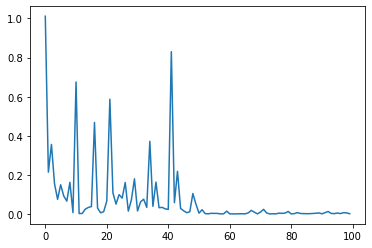

In [104]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(bottom=-0.0001,top=100)

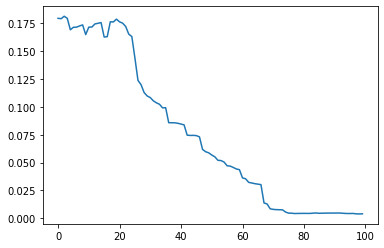

In [105]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

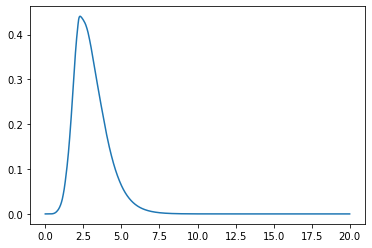

In [106]:
x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

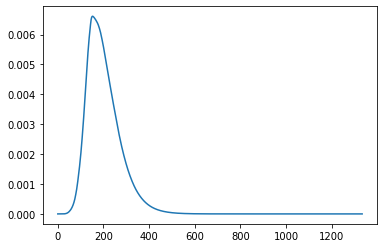

In [107]:
x = torch.Tensor(np.arange(0.001, 20 , 0.01)).to(device).unsqueeze(-1)
p = model(x) 
plt.plot(x.cpu().detach().numpy() * LAMBDA, p.cpu().detach().numpy() / LAMBDA)

In [108]:
p

tensor([[1.6777e-23],
        [6.9258e-16],
        [7.7880e-14],
        ...,
        [1.8037e-11],
        [1.7751e-11],
        [1.7470e-11]], grad_fn=<SoftplusBackward0>)

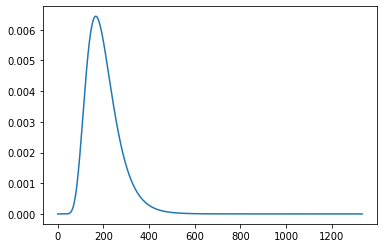

In [109]:
x = np.linspace(0.0001, 20 * LAMBDA, num = 10000)
y = lognorm.pdf(x , s=VOLATILITY, loc=0, scale=np.exp(PROPOSAL_MU))
plt.plot(x, y)

In [110]:
for para in model.parameters():
    print(para)

Parameter containing:
tensor([[-2.2564e-01, -6.6895e-02],
        [-2.5685e-01,  6.1773e-01],
        [-4.5894e-01, -1.4985e-01],
        [ 6.3803e-01, -7.0306e-01],
        [-5.7649e-01, -3.8048e-01],
        [-3.0829e-03,  6.3148e-01],
        [-7.6535e-02, -7.0979e-02],
        [ 2.9310e-01, -4.0425e-01],
        [-7.1817e-03, -2.9990e-01],
        [ 2.1001e-01,  5.1112e-01],
        [-1.1510e-01, -4.2933e-02],
        [ 4.9788e-01,  6.2530e-01],
        [-6.0432e-01,  2.5942e-01],
        [ 6.9896e-01,  2.0544e-01],
        [ 5.1026e-01,  2.4028e-01],
        [-3.2635e-01,  1.1952e-01],
        [-6.6958e-01, -5.4792e-01],
        [ 2.9353e-01,  4.8632e-01],
        [ 2.1280e-02, -5.9541e-01],
        [ 5.4212e-01,  5.9657e-02],
        [ 2.4400e-01,  5.1609e-01],
        [-2.2230e-01, -1.1052e-01],
        [-5.3237e-01,  7.6702e-02],
        [-1.5630e-01, -4.0841e-01],
        [ 3.5415e-01,  6.2218e-01],
        [-1.0733e-02,  5.4412e-01],
        [-2.6414e-01, -1.4266e-01],
      

#Testing

In [129]:
def price_option(model, x, strike, spot, is_call):
    densities = model.forward(x)
    print(densities.shape)
    print(x.shape)
    payoff = torch.max( torch.zeros(list(x.shape)),  x - strike ) if is_call else torch.max(torch.zeros(list(x.shape)), strike - x )
    print(payoff)
    print(densities)
    sampling_density = 1 / INTERVAL_LENGTH
    return sum(densities*payoff) / sampling_density / MC_STEPS


In [111]:
with torch.no_grad():
  total_loss = 0
  for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
          MC_STEPS = MC_STEPS_FINAL
          X = torch.zeros(MC_STEPS, 1).to(device)
          X.uniform_(0.01, INTERVAL_LENGTH)
          pred = model(X)
          loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
          total_loss += loss        

In [112]:
print(total_loss)

tensor(0.3794, dtype=torch.float64)


In [113]:
print(total_loss/TOT_OPTIONS)

tensor(0.0004, dtype=torch.float64)


In [114]:
test_prices_scaled
scaled_strikes
spots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)

In [134]:
i = 600
print(test_strikes_scaled[i])
print(is_call_options[i])
print(test_prices_scaled[i])

5.253006012024048
True
tf.Tensor(0.03188979474342383, shape=(), dtype=float64)


In [135]:
X = torch.zeros(MC_STEPS, 1).to(device)
X.uniform_(0.01, INTERVAL_LENGTH)
price = price_option(model, X, test_strikes_scaled[i], spots_scaled[i], is_call_options[i] )
print(price)
print(test_prices_scaled[i])


torch.Size([16384, 1])
torch.Size([16384, 1])
tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.0000],
        [0.0000],
        [4.4940]])
tensor([[3.8852e-03],
        [1.8828e-06],
        [3.2766e-01],
        ...,
        [3.9408e-01],
        [4.1839e-01],
        [1.1748e-04]], grad_fn=<SoftplusBackward0>)
tensor([0.0286], grad_fn=<DivBackward0>)
tf.Tensor(0.03188979474342383, shape=(), dtype=float64)


In [126]:
MC_STEPS

16384